Whatsapp : 7795880966 

Mail : reachninadaithal@gmail.com

    networks = {
        'cerebellum': 18,
        'cingulo-opercular':32,
        'default_mode':34,
        'frontoparietal':21,
        'occipital': 22,
        'sensorimotor':33
    }

In [1]:
'''
Import necessary libraries
'''
import numpy as np 
import pandas as pd
import os
import optuna
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from PIL import Image
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader, WeightedRandomSampler, Dataset
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import torchvision.models as models
from torch.nn.parallel import DataParallel
from torchvision.transforms import ToTensor
from torchvision import transforms
import torchvision.utils as vutils
import torch.optim as optim
from torchinfo import summary

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
networks = {
    'cerebellum': 18,
    'cingulo-opercular':32,
    'default_mode':34,
    'frontoparietal':21,
    'occipital': 22,
    'sensorimotor':33
}

# HYPERPARAMETERS

PRETRAINED = False
NETWORK = 'sensorimotor'
ROIS = networks[NETWORK]
SEED = 64
LEARNING_RATE = 1e-3
BATCH_SIZE = 16
TRAIN_TEST_SPLIT = 0.2
OPTIMIZER = 'Adam'
DATASET_PATH = f'link/to/dataset/{NETWORK}'
PRETRAINED_MODEL_PATH = f'link/to/autoencoder{NETWORK}.pt'
NUM_EPOCHS = 1000
EMBEDDING_CHANNELS = 3
EMBEDDING_SIZE = 0

In [3]:
def show(data1, data2):
    '''function to visually compare the reconstructed image with the input images
    Each subject is represented by 2 rows and each pair of column corresponds to a ROI
    We can centre Crop the images before feeding to the Autoencoder (Custom Dataset)to get rid of the yellow border ,,
    '''

    fig, axes = plt.subplots(2, 10, figsize=(15, 3))

    for i in range(0, 2):
        for j in range(0, 10, 2):
            ax1 = axes[i][j]
            channel1 = data1[i * 5 + j]
            ax1.imshow(channel1, cmap='viridis', vmin=-1, vmax=1)  # Specify vmin and vmax for the [0, 1] range
            ax1.axis('off')
            ax1.set_title('original')

            ax2 = axes[i][j + 1]
            channel2 = data2[i * 5 + (j // 2)]
            ax2.imshow(channel2, cmap='viridis', vmin=-1, vmax=1)  # Specify vmin and vmax for the [0, 1] range
            ax2.axis('off')
            ax2.set_title('reconstructed')

    plt.show()

In [4]:
class AutoEncoderDataset(Dataset):
    '''
    Dataset class AutoEncoderDataset get's the resized recurrence and stacks the singel channel image to make the input as a multichannel image 
    ROIi corresponds to ith channel in all datapoints
    '''
    def __init__(self, root_dir, in_num_channels, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.labels = []

        self.samples = []
        label_dict = {'healthy': 0, 'mci': 1}

        for class_name in ['healthy', 'mci']:
            class_dir = os.path.join(root_dir, class_name)

            for file_name in os.listdir(class_dir):
                if file_name.endswith("14state.png"):
                    paths = [os.path.join(class_dir, file_name.replace("14state.png", f"{i}state.png")) for i in range(1,in_num_channels+1)]
                    if all(os.path.exists(path) for path in paths):
                        label = os.path.join(class_dir, file_name.replace("14state.png", "state"))
                        new_label = (label.split('/')[-2],label.split('/')[-1][:-9])
                        self.samples.append((paths, new_label))
                        self.labels.append(new_label)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        paths, label = self.samples[idx]
        images = []

        for path in paths:
            image = Image.open(path)
            transform = transforms.Compose([
                transforms.Grayscale(num_output_channels=1),
                transforms.CenterCrop(170),
                transforms.Resize(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5], std=[0.5])
            ])
            image_tensor = transform(image)
            images.append(image_tensor)
            
        combined_image = torch.stack(images, dim=1).squeeze()

        if self.transform:
            image = self.transform(combined_image)
        else:
            image = combined_image
        return image, label

In [5]:
class Autoencoder(nn.Module):
    def __init__(self, rois, emb_channels):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            # rois x 224 x 224
            nn.Conv2d(rois, 64, kernel_size=3, padding=1),
            nn.SiLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.SiLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            # 64 x 112 x 112
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.SiLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.SiLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            # 128 x 56 x 56
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.SiLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.SiLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2, 2),
            # 256 x 28 x 28
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.SiLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.SiLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2, 2),
            # 512 x 28 x 28
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.SiLU(),
            nn.BatchNorm2d(1024),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.SiLU(),
            nn.BatchNorm2d(1024),
        )

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(1024, emb_channels, kernel_size=3, padding=1),
            nn.SiLU(),
            nn.BatchNorm2d(emb_channels),
            nn.Dropout(0.5),
        )

        self.decoder = nn.Sequential(
            # 1024 x 14 x 14
            nn.ConvTranspose2d(emb_channels, 1024, kernel_size=3, padding=1),
            nn.SiLU(),
            nn.BatchNorm2d(1024),
            nn.ConvTranspose2d(1024, 1024, kernel_size=3, padding=1),
            nn.SiLU(),
            nn.BatchNorm2d(1024),
            # 512 x 28 x 28
            nn.ConvTranspose2d(1024, 512, kernel_size=3, padding=1),
            nn.SiLU(),
            nn.BatchNorm2d(512),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.SiLU(),
            nn.BatchNorm2d(256),
            # 256 x 28 x 28
            nn.ConvTranspose2d(256, 256, kernel_size=3, padding=1),
            nn.SiLU(),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.SiLU(),
            nn.BatchNorm2d(128),
            # 128 x 56 x 56
            nn.ConvTranspose2d(128, 128, kernel_size=3, padding=1),
            nn.SiLU(),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.SiLU(),
            nn.BatchNorm2d(64),
            # 64 x 112 x 112
            nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1),
            nn.SiLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, rois, kernel_size=3, stride=2, padding=1, output_padding=1),
        )


    def forward(self, x):
        x = self.encoder(x)
        bottleneck_output = self.bottleneck(x)
        x = self.decoder(bottleneck_output)
        return x, bottleneck_output

In [6]:
autoencoder_model = Autoencoder(ROIS, EMBEDDING_CHANNELS)
summary(autoencoder_model, input_size=(BATCH_SIZE,ROIS,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder                              [16, 33, 224, 224]        --
├─Sequential: 1-1                        [16, 1024, 14, 14]        --
│    └─Conv2d: 2-1                       [16, 64, 224, 224]        19,072
│    └─SiLU: 2-2                         [16, 64, 224, 224]        --
│    └─BatchNorm2d: 2-3                  [16, 64, 224, 224]        128
│    └─Conv2d: 2-4                       [16, 64, 224, 224]        36,928
│    └─SiLU: 2-5                         [16, 64, 224, 224]        --
│    └─BatchNorm2d: 2-6                  [16, 64, 224, 224]        128
│    └─MaxPool2d: 2-7                    [16, 64, 112, 112]        --
│    └─Conv2d: 2-8                       [16, 128, 112, 112]       73,856
│    └─SiLU: 2-9                         [16, 128, 112, 112]       --
│    └─BatchNorm2d: 2-10                 [16, 128, 112, 112]       256
│    └─Conv2d: 2-11                      [16, 128, 112, 112]       147

In [7]:
torch.manual_seed(SEED)

#%%%%%%%%%%%%%%%%%%%%%%%     DATASET CREATION   %%%%%%%%%%%%%%%%%%%%%%%
custom_dataset = AutoEncoderDataset(root_dir=DATASET_PATH, in_num_channels=ROIS)
val_size = int(len(custom_dataset) * TRAIN_TEST_SPLIT)
train_size = len(custom_dataset) - val_size
train_ds, val_ds = random_split(custom_dataset, [train_size, val_size])
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE)

if PRETRAINED :
    #%%%%%%%%%%%%%%%%%%%%%%%     PRE TRAINED MODEL   %%%%%%%%%%%%%%%%%%%%%%%
    autoencoder_model = Autoencoder(ROIS, EMBEDDING_CHANNELS)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    autoencoder_model = autoencoder_model.to(device)
    state_dict = torch.load(PRETRAINED_MODEL_PATH)
    new_state_dict = {}
    for key, value in state_dict.items():
        new_key = key.replace("module.", "")  # Remove "module." prefix
        new_state_dict[new_key] = value

    autoencoder_model.load_state_dict(new_state_dict)
    autoencoder_model = DataParallel(autoencoder_model)
    criterion = nn.MSELoss()
    if OPTIMIZER == 'SGD':
        optimizer = optim.SGD(autoencoder_model.parameters(), lr=LEARNING_RATE, momentum=0.9)
    elif OPTIMIZER == 'Adam':
        optimizer = optim.Adam(autoencoder_model.parameters(), lr=LEARNING_RATE)
else :
    # #%%%%%%%%%%%%%%%%%%%%%%%     MODEL   %%%%%%%%%%%%%%%%%%%%%%%
    autoencoder_model = Autoencoder(ROIS, EMBEDDING_CHANNELS)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    autoencoder_model = autoencoder_model.to(device)
    autoencoder_model = DataParallel(autoencoder_model)
    criterion = nn.MSELoss()
    if OPTIMIZER == 'SGD':
        optimizer = optim.SGD(autoencoder_model.parameters(), lr=LEARNING_RATE, momentum=0.9)
    elif OPTIMIZER == 'Adam':
        optimizer = optim.Adam(autoencoder_model.parameters(), lr=LEARNING_RATE)
    #%%%%%%%%%%%%%%%%%%%%%%%     MODEL TRAINING   %%%%%%%%%%%%%%%%%%%%%%%
    train_losses = []
    val_losses = []

    for epoch in range(NUM_EPOCHS):
        autoencoder_model.train()
        train_loss = 0.0
        for inputs, labels in train_dl:
            inputs = inputs.to(device)
            optimizer.zero_grad()
            outputs = autoencoder_model(inputs)
            loss = criterion(outputs[0], inputs)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        autoencoder_model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_dl:
                inputs = inputs.to(device)
                outputs = autoencoder_model(inputs)
                loss = criterion(outputs[0], inputs)
                val_loss += loss.item()

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        if (epoch + 1) % 5 == 0:
            print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]: Train Loss: {train_loss:.5f} Val Loss: {val_loss:.5f}")

    torch.save(autoencoder_model.state_dict(), 'autoencoder.pt')

Epoch [5/1000]: Train Loss: 0.29975 Val Loss: 0.10719
Epoch [10/1000]: Train Loss: 0.26028 Val Loss: 0.10014
Epoch [15/1000]: Train Loss: 0.23840 Val Loss: 0.08875
Epoch [20/1000]: Train Loss: 0.23003 Val Loss: 0.08569
Epoch [25/1000]: Train Loss: 0.22745 Val Loss: 0.08362
Epoch [30/1000]: Train Loss: 0.21956 Val Loss: 0.08088
Epoch [35/1000]: Train Loss: 0.21872 Val Loss: 0.08036
Epoch [40/1000]: Train Loss: 0.21307 Val Loss: 0.07726
Epoch [45/1000]: Train Loss: 0.21072 Val Loss: 0.07737
Epoch [50/1000]: Train Loss: 0.21212 Val Loss: 0.07711
Epoch [55/1000]: Train Loss: 0.20756 Val Loss: 0.07729
Epoch [60/1000]: Train Loss: 0.20908 Val Loss: 0.07564
Epoch [65/1000]: Train Loss: 0.20694 Val Loss: 0.07669
Epoch [70/1000]: Train Loss: 0.20632 Val Loss: 0.07702
Epoch [75/1000]: Train Loss: 0.20597 Val Loss: 0.07661
Epoch [80/1000]: Train Loss: 0.20598 Val Loss: 0.07643
Epoch [85/1000]: Train Loss: 0.20352 Val Loss: 0.07654
Epoch [90/1000]: Train Loss: 0.20219 Val Loss: 0.07623
Epoch [95/1

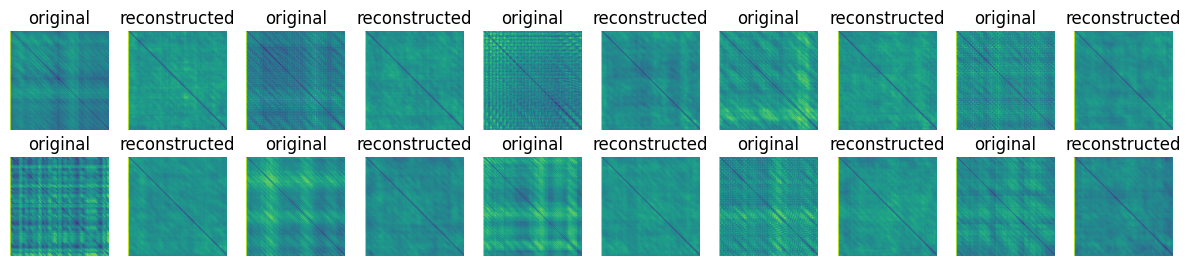

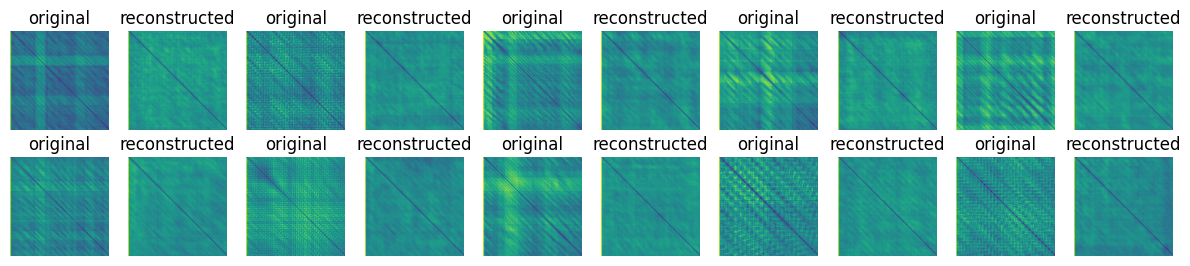

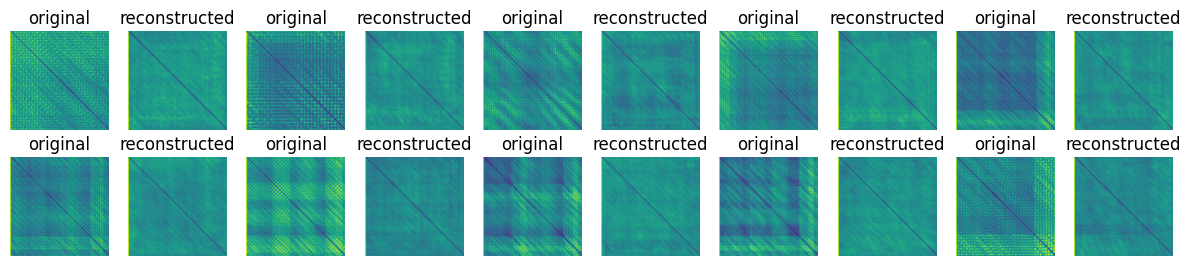

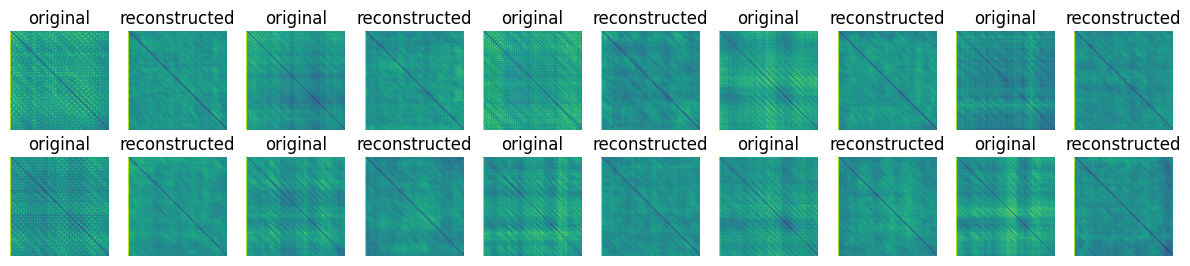

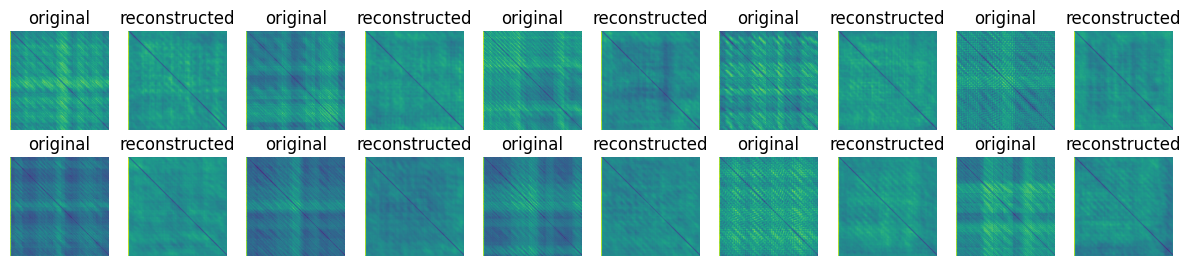

In [8]:
# check the goodness of the reconstruction
autoencoder_model.eval()
with torch.no_grad():
    for inputs, labels in val_dl:
        inputs = inputs.to(device)
        outputs = autoencoder_model(inputs)
        for k in range(5):
            show(inputs[k].to('cpu').numpy(), outputs[0][k].to('cpu').numpy())
        break

In [9]:
# Get the Latent space embeddings

embedded_data = {'healthy':{}, 'mci':{}}
embedding_dataset = AutoEncoderDataset(root_dir=DATASET_PATH, in_num_channels=ROIS)
embedding_dl = DataLoader(embedding_dataset, batch_size=BATCH_SIZE)

In [10]:
autoencoder_model.eval()
with torch.no_grad():
    for inputs, labels in embedding_dl:
        inputs = inputs.to(device)
#         print(inputs.shape)
        _, embedding = autoencoder_model(inputs)
        for k, (class_, subj) in enumerate(zip(labels[0], labels[1])):
            subj_no = int(subj[-2:])
            if subj_no < 0 :
                embedded_data[class_][subj_no*(-1)] = embedding[k].cpu().numpy()
            else:
                embedded_data[class_][subj_no] = embedding[k].cpu().numpy()

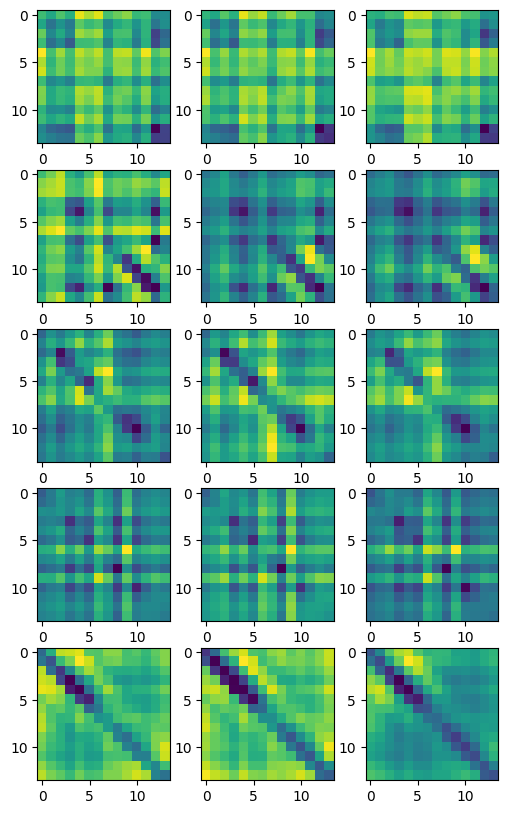

In [11]:
# visualise the embeddings
plt.figure(figsize=(6,10))
for i in range(1, 5*EMBEDDING_CHANNELS, EMBEDDING_CHANNELS):
    for channel in range(EMBEDDING_CHANNELS):
        plt.subplot(5, EMBEDDING_CHANNELS, i + channel)
        plt.imshow(embedded_data['healthy'][i][channel])

plt.show()

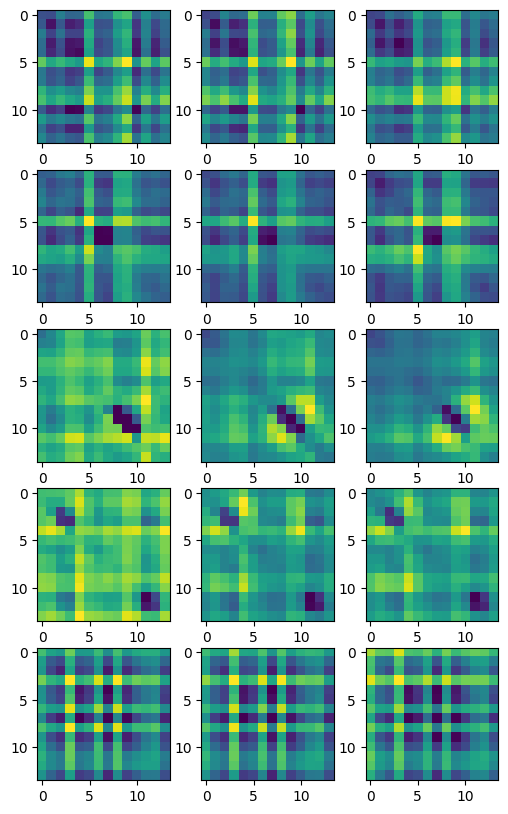

In [12]:
plt.figure(figsize=(6,10))
for i in range(1, 5*EMBEDDING_CHANNELS, EMBEDDING_CHANNELS):
    for channel in range(EMBEDDING_CHANNELS):
        plt.subplot(5, EMBEDDING_CHANNELS, i + channel)
        plt.imshow(embedded_data['mci'][i][channel])

plt.show()

In [13]:
class EmbeddedDataset(Dataset):
    '''Dataset class for classifying the latent space representation
    '''
    def __init__(self, class1_dict, class2_dict):
        self.class1_data = list(class1_dict.values())
        self.class2_data = list(class2_dict.values())
        self.class1_labels = [0] * len(self.class1_data)
        self.class2_labels = [1] * len(self.class2_data)
        self.data = self.class1_data + self.class2_data
        self.labels = self.class1_labels + self.class2_labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        data = torch.Tensor(self.data[index])
        label = self.labels[index]
        return data, label

emb_data = EmbeddedDataset(embedded_data['healthy'], embedded_data['mci'])
test_size = int(len(emb_data) * 0.15)
val_size = int(len(emb_data) * 0.15)
train_size = len(emb_data) - val_size - test_size
train_ds, val_ds , test_ds = random_split(emb_data, [train_size, val_size, test_size])
train_dl = DataLoader(train_ds, batch_size=4)
val_dl = DataLoader(val_ds, batch_size=4)
test_dl = DataLoader(test_ds, batch_size=4)

In [14]:
class SimpleCNN(nn.Module):
    def __init__(self, in_channels=1):
        super(SimpleCNN, self).__init__()
        self.model = nn.Sequential(
            # input 1 x 14 x 14
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(128*7*7, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)  # Two output classes for binary classification
        )

    def forward(self, x):
        return self.model(x)

# summary(classfier_model, input_size=(4, 1, 14, 14))

In [15]:
classfier_model = SimpleCNN(EMBEDDING_CHANNELS)
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = classfier_model.to(device)
model = DataParallel(model)

criterion = nn.CrossEntropyLoss()
optimizer_type = 'Adam'
learning_rate = 5e-4

if optimizer_type == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
elif optimizer_type == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 100

#%%%%%%%%%%%%%%%%%%%%%%%     MODEL TRAINING   %%%%%%%%%%%%%%%%%%%%%%%
train_losses = []
val_losses = []
train_accu = []
val_accu = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for inputs, labels in train_dl:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        train_loss += loss.item()
    train_accuracy = 100 * train_correct / train_total

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_dl:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()  # Accumulate validation loss

            # Compute validation accuracy
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = 100 * val_correct / val_total
    val_loss /= len(val_dl)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accu.append(train_accuracy)
    val_accu.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}]: "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

Epoch [1/100]: Train Loss: 12.4458, Train Accuracy: 52.17%, Val Loss: 0.6975, Val Accuracy: 42.86%
Epoch [2/100]: Train Loss: 12.3851, Train Accuracy: 53.62%, Val Loss: 0.6957, Val Accuracy: 35.71%
Epoch [3/100]: Train Loss: 11.4482, Train Accuracy: 68.12%, Val Loss: 0.7859, Val Accuracy: 42.86%
Epoch [4/100]: Train Loss: 8.8681, Train Accuracy: 75.36%, Val Loss: 0.6569, Val Accuracy: 50.00%
Epoch [5/100]: Train Loss: 7.4481, Train Accuracy: 78.26%, Val Loss: 0.6948, Val Accuracy: 57.14%
Epoch [6/100]: Train Loss: 4.5202, Train Accuracy: 86.96%, Val Loss: 1.1757, Val Accuracy: 50.00%
Epoch [7/100]: Train Loss: 7.2614, Train Accuracy: 82.61%, Val Loss: 0.8043, Val Accuracy: 50.00%
Epoch [8/100]: Train Loss: 3.8964, Train Accuracy: 89.86%, Val Loss: 0.9214, Val Accuracy: 50.00%
Epoch [9/100]: Train Loss: 1.0183, Train Accuracy: 98.55%, Val Loss: 0.7105, Val Accuracy: 85.71%
Epoch [10/100]: Train Loss: 2.5870, Train Accuracy: 95.65%, Val Loss: 0.9471, Val Accuracy: 78.57%
Epoch [11/100]: 

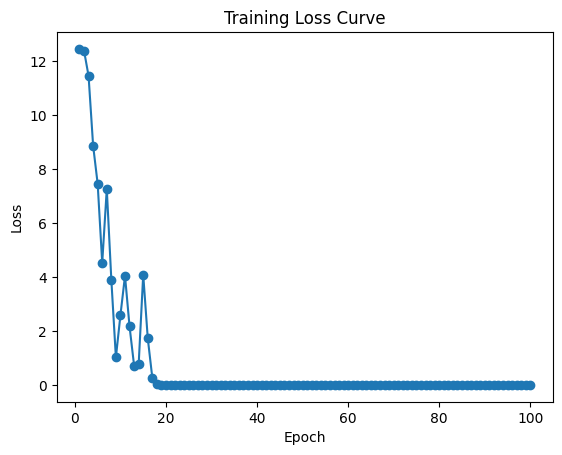

In [16]:
epochs = list(range(1, len(train_losses) + 1))

plt.plot(epochs, train_losses, marker='o')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
# plt.savefig(f'{network}training_loss_curve.png')
# plt.close()

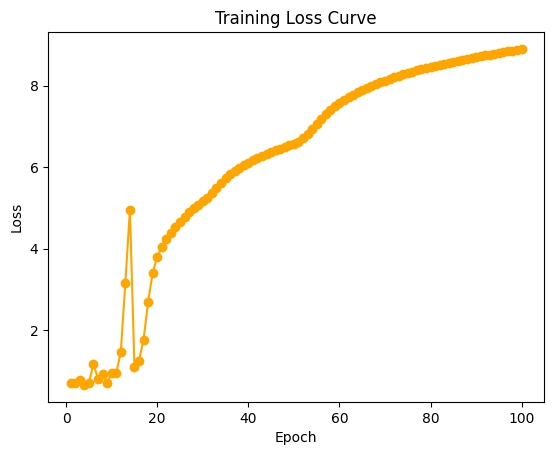

In [17]:
plt.plot(epochs, val_losses, marker='o', color = 'orange')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
# plt.savefig(f'{network}validation_loss_curve.png')
# plt.close()

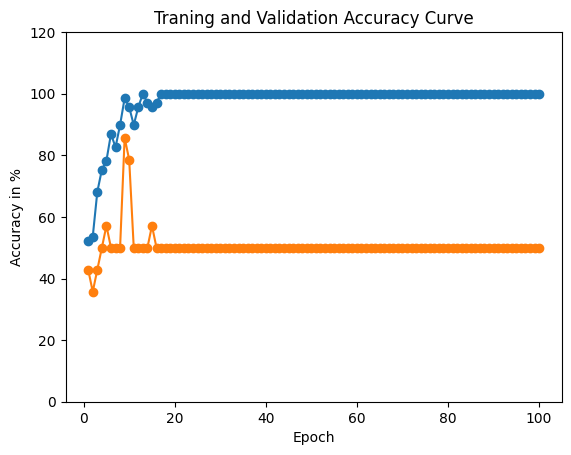

In [18]:
plt.plot(epochs, train_accu, marker='o')
plt.plot(epochs, val_accu, marker='o')
plt.title('Traning and Validation Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy in %')
plt.ylim(0,120)
plt.show()
# plt.savefig(f'{network}accuracy_curve.png')
# plt.close()

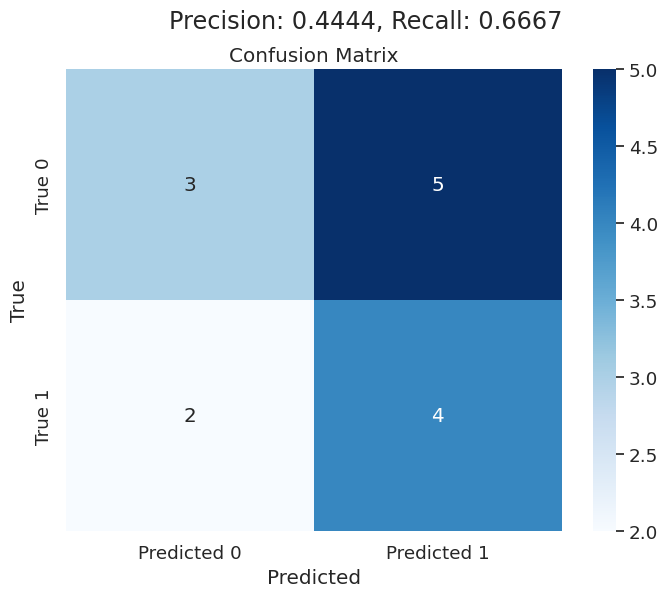

In [19]:
num_classes = 2  
conf_matrix = np.zeros((num_classes, num_classes), dtype=int)

model.eval()

with torch.no_grad():
    for inputs, labels in val_dl:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)  # Convert to int (0 or 1)

        conf_matrix += confusion_matrix(labels.cpu(), predicted.cpu(), labels=[0, 1])


TP = conf_matrix[1, 1]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]

precision = TP / (TP + FP)
recall = TP / (TP + FN)

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["True 0", "True 1"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.suptitle(f'Precision: {precision:.4f}, Recall: {recall:.4f}')
plt.show()
# plt.savefig(f'{network}confusion_mat.png')
# plt.close()

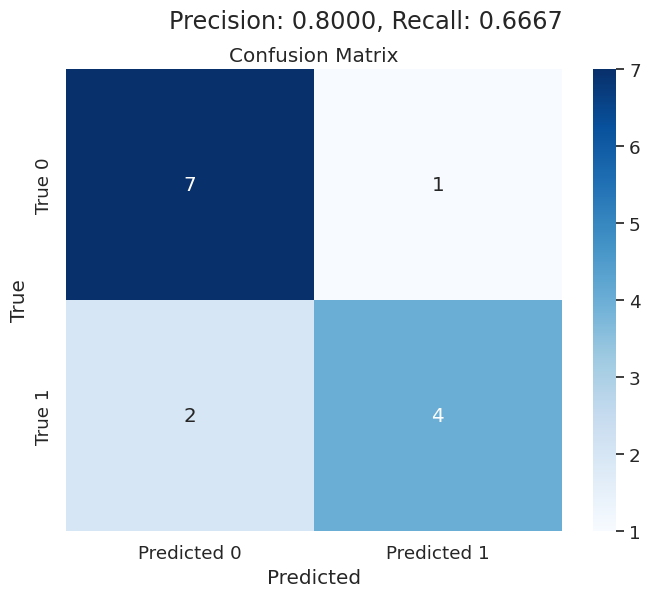

In [20]:
num_classes = 2  
conf_matrix = np.zeros((num_classes, num_classes), dtype=int)

model.eval()

with torch.no_grad():
    for inputs, labels in test_dl:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)  # Convert to int (0 or 1)

        conf_matrix += confusion_matrix(labels.cpu(), predicted.cpu(), labels=[0, 1])


TP = conf_matrix[1, 1]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]

precision = TP / (TP + FP)
recall = TP / (TP + FN)

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["True 0", "True 1"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.suptitle(f'Precision: {precision:.4f}, Recall: {recall:.4f}')
plt.show()
# plt.savefig(f'{network}confusion_mat.png')
# plt.close()